# DAMI II Project, Alfred Larsson, ALLA8206, NBA Draft predictions with various algorithms 
## Load the libraries that will be used during the project

In [1]:
#libraries that was used throuhougt the project.
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import Perceptron
RSEED = 7

## Preprocessing
### Load the data, fill in NaN values for draft "pick" data column and drop NaN for other values

In [2]:
#Specify the path based on your machine
file_path = "CollegeBasketballPlayers2009-2021.csv"

#Read the CSV file to a pandas dataframe
data_all = pd.read_csv(file_path, low_memory=False)

#Print the value count for the player names to identify unique players
print(data_all["player_name"].value_counts)

#All non drafted players NaN value was changed to 0
data_all["pick"].fillna(0, inplace=True) 


#Uncomment the draft parameters used, 2 different options 15 and 6 parameters
#data_parameters_used = ["pick", "Min_per", "Ortg", 'pts', "eFG", "TS_per", "ORB_per", "DRB_per", "AST_per", "FT_per", "twoP_per", "TP_per", "porpag", 'dporpag', "mp"]
data_parameters_used = ["pick", 'Min_per', 'pts',  'dporpag', 'porpag', "mp"]

#Parameters to use to determie draft status, exluding the "pick" class, uncomment what is used, have to match the "draft_parameters_used minus the "pick"
#draft_parameters = ["Min_per", "Ortg", 'pts', "eFG", "TS_per", "ORB_per", "DRB_per", "AST_per", "FT_per", "twoP_per", "TP_per", "porpag", 'dporpag', "mp"]
draft_parameters = ['Min_per', 'pts',  'dporpag', 'porpag', "mp"]

#Create a data set used for the modeling and evaluation 
data = data_all[data_parameters_used].copy()
data.dropna(inplace=True) #remaining players that had NaN values rows were dropped

#Run a descriobe on the data for initial evaluation 
data.describe()

<bound method IndexOpsMixin.value_counts of 0             DeAndrae Ross
1             Pooh Williams
2             Jesus Verdejo
3           Mike Hornbuckle
4             Anthony Brown
                ...        
61056        Trey Patterson
61057    Stavros Polatoglou
61058            Sandy Ryan
61059             Ty Larson
61060           Jaden Jones
Name: player_name, Length: 61061, dtype: object>


,pick,Min_per,pts,dporpag,porpag,mp
count,61015.000000,61015.000000,61015.000000,61015.000000,61015.000000,61015.000000
mean,0.779972,37.155609,5.774140,1.436595,0.773659,16.942191
std,5.637460,28.050911,4.947918,1.064952,1.333222,10.617828
min,0.000000,0.000000,0.000000,-0.857238,-6.792410,0.000000
25%,0.000000,9.300000,1.571400,0.521432,-0.174382,7.266700
50%,0.000000,35.700000,4.484800,1.263410,0.392244,16.666700
75%,0.000000,62.000000,9.064500,2.172415,1.487340,26.285700
max,60.000000,98.000000,30.090900,5.800530,8.658190,50.000000


In [3]:
#Count the values of different draft picks
data["pick"].value_counts()

0.0     59580
46.0       35
38.0       34
58.0       33
49.0       33
        ...  
16.0       14
1.0        13
31.0       13
3.0        11
7.0        11
Name: pick, Length: 61, dtype: int64

In [4]:
#The current data for picks displays in what number the player was drafted. To blance the problem we change the draft values for drafted players to 1, where and undrafted player Was assigned 0
data["pick"] = np.where((data["pick"]>0),1,0)

#Count the unique values to determine how many players are drafted or not
data["pick"].value_counts()

0    59580
1     1435
Name: pick, dtype: int64

Results indicate that there were 1435 instances where a player got drafted after a season and 59588 instances when a player did not get drafted, ~2.3% of the players get drafted

In [5]:
## Checking to see if we have any null values left in our dataset 
data.isnull().any()

pick       False
Min_per    False
pts        False
dporpag    False
porpag     False
mp         False
dtype: bool

In [6]:
#Standarize the data
scaler = StandardScaler().fit(data[draft_parameters])

#Create a new pandas dataframe based on the scaled data
data_scaled = pd.DataFrame(scaler.transform(data[draft_parameters]), columns=draft_parameters)

In [7]:
#Validate the standarized data
data_scaled.describe()

,Min_per,pts,dporpag,porpag,mp
count,6.101500e+04,6.101500e+04,6.101500e+04,6.101500e+04,6.101500e+04
mean,-5.204028e-17,1.075305e-16,-3.975441e-17,-7.753911e-17,-1.686178e-16
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.324588e+00,-1.166993e+00,-2.153950e+00,-5.675074e+00,-1.595649e+00
25%,-9.930457e-01,-8.494025e-01,-8.593546e-01,-7.110959e-01,-9.112571e-01
50%,-5.189212e-02,-2.605844e-01,-1.626237e-01,-2.860873e-01,-2.594632e-02
75%,8.856965e-01,6.650043e-01,6.909479e-01,5.353103e-01,8.799903e-01
max,2.169088e+00,4.914584e+00,4.097812e+00,5.913943e+00,3.113450e+00


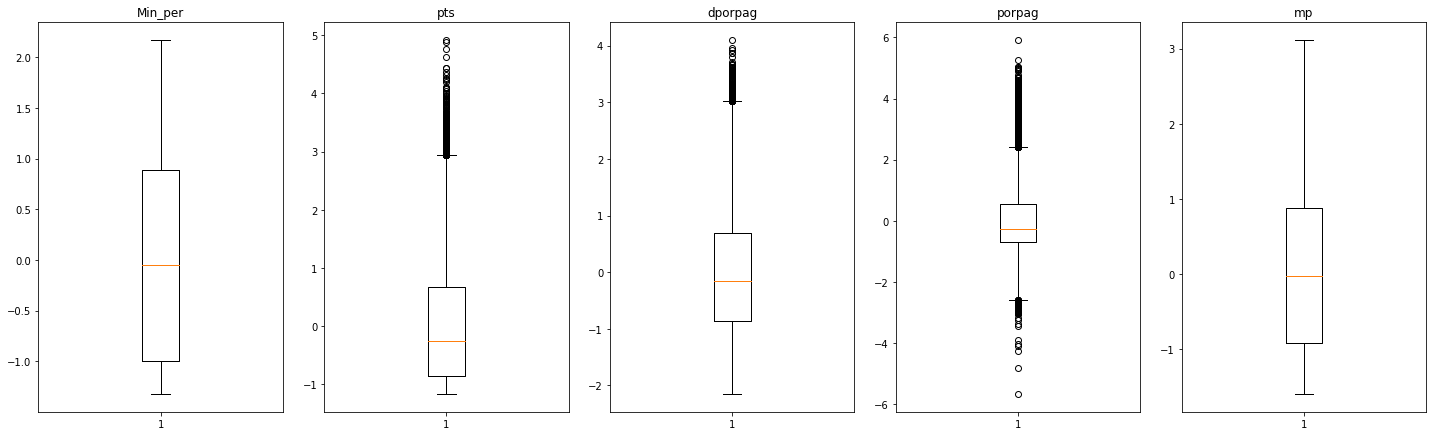

In [8]:
#Checking out outliers with boxplots
fig, ax = plt.subplots(1, len(draft_parameters))
fig.set_size_inches(20, 6)
plt.tight_layout()
for i in range(len(draft_parameters)):
    ax[i].boxplot(data_scaled[data_scaled.columns[i]])
    ax[i].set_title(data_scaled.columns[i])


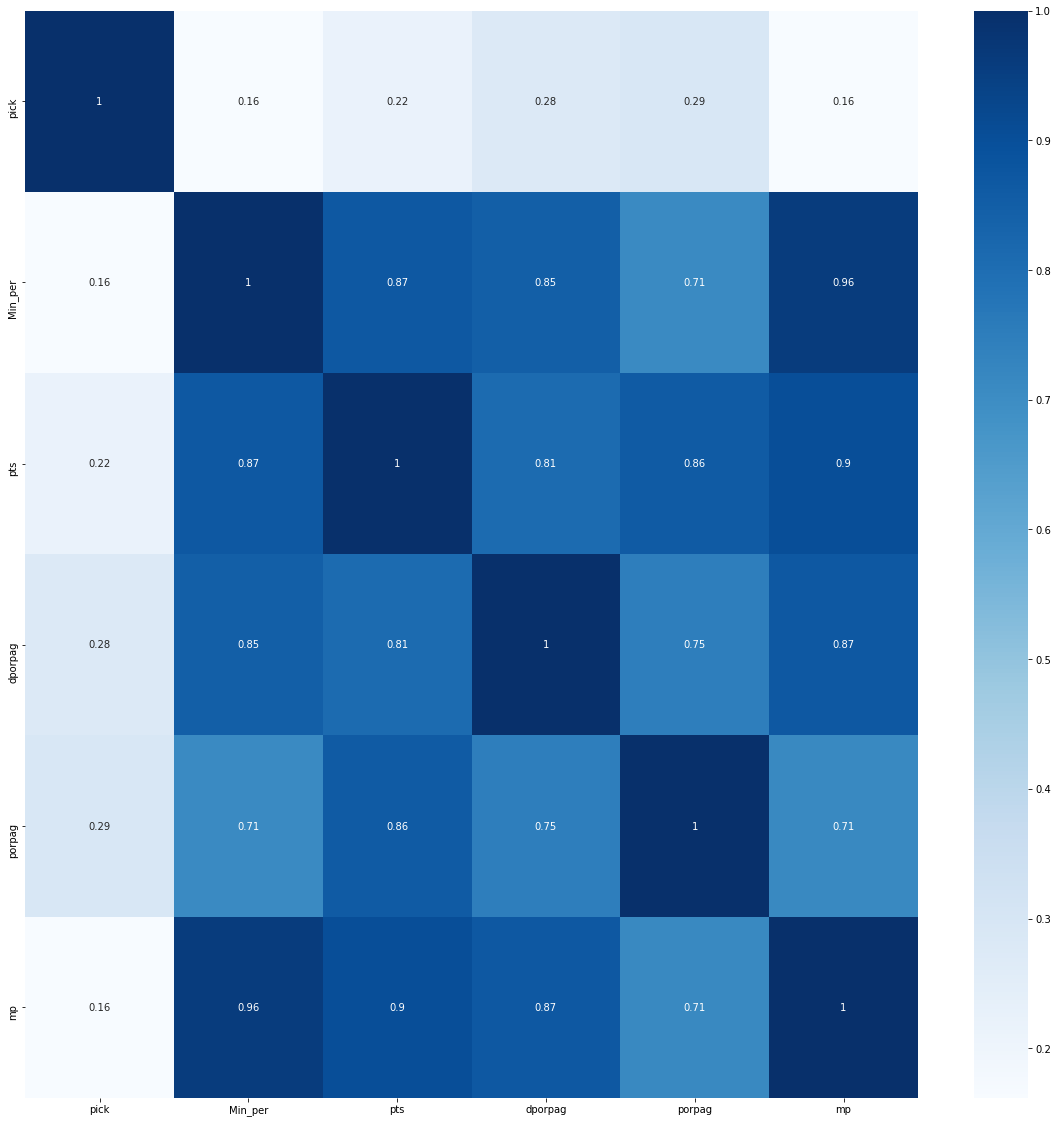

In [9]:
#Using Pearson Correlation, computes pairwise correlation of columns, plots rectangular data as a color-encoded matrix, evaluate correlation to the "pick" class

plt.figure(figsize=(20,20))
cor = data[data_parameters_used].corr()
sns.heatmap(data=cor, annot=True, cmap=plt.cm.Blues);
plt.show()

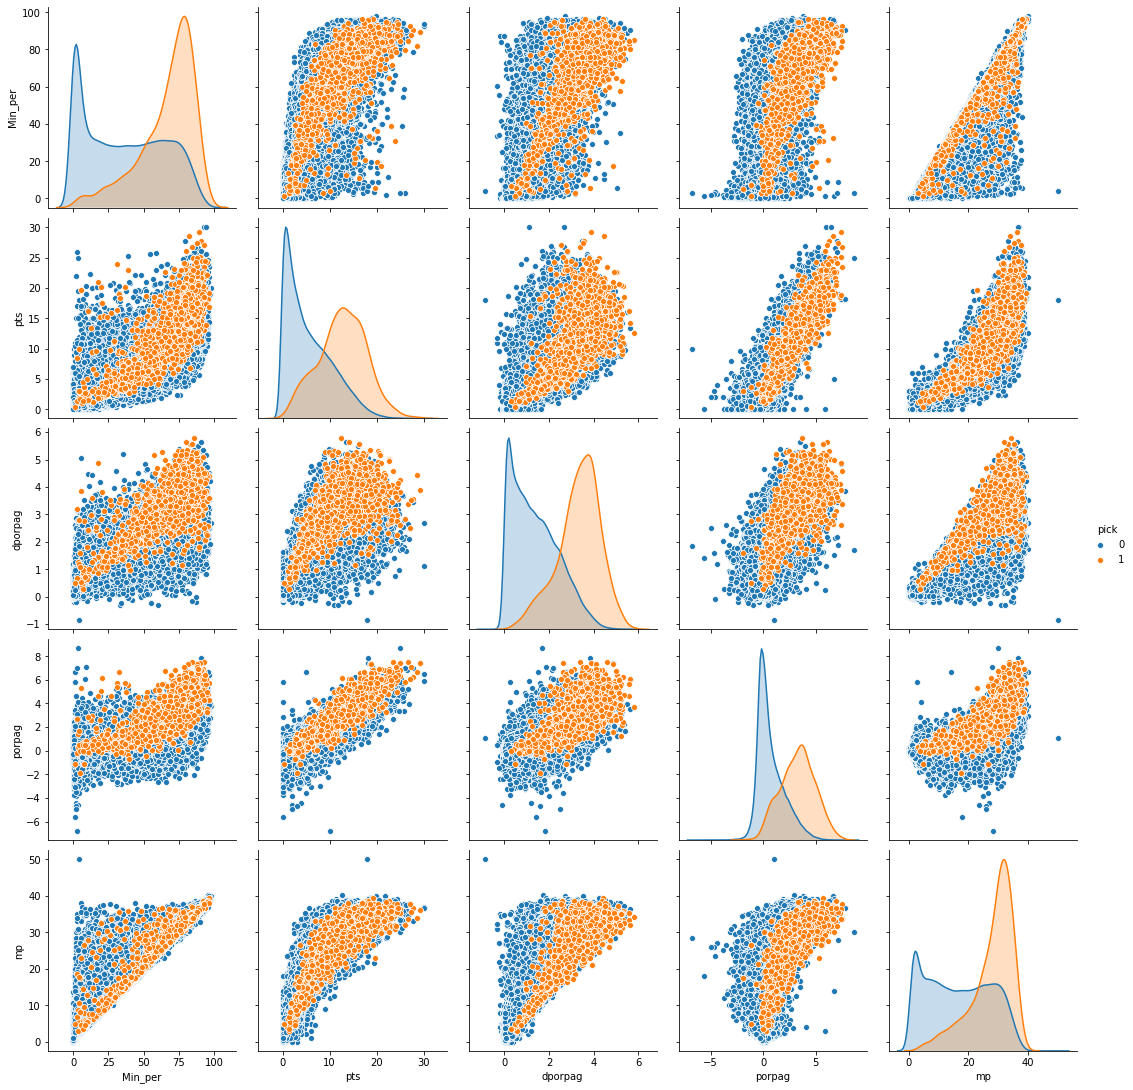

In [10]:
#Create a pairplot to further investigate the pairwise relationship 
sns.pairplot(data[data_parameters_used], hue="pick", height=3)


In [11]:
#Split up the data to variables and classifier 
X = pd.DataFrame(data_scaled[draft_parameters], columns=draft_parameters)
y = pd.Series(data["pick"])

In [12]:
y.describe()

count    61015.000000
mean         0.023519
std          0.151546
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pick, dtype: float64

In [13]:
X.describe()

,Min_per,pts,dporpag,porpag,mp
count,6.101500e+04,6.101500e+04,6.101500e+04,6.101500e+04,6.101500e+04
mean,-5.204028e-17,1.075305e-16,-3.975441e-17,-7.753911e-17,-1.686178e-16
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.324588e+00,-1.166993e+00,-2.153950e+00,-5.675074e+00,-1.595649e+00
25%,-9.930457e-01,-8.494025e-01,-8.593546e-01,-7.110959e-01,-9.112571e-01
50%,-5.189212e-02,-2.605844e-01,-1.626237e-01,-2.860873e-01,-2.594632e-02
75%,8.856965e-01,6.650043e-01,6.909479e-01,5.353103e-01,8.799903e-01
max,2.169088e+00,4.914584e+00,4.097812e+00,5.913943e+00,3.113450e+00


In [14]:
#Split up training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

## Perceptron



In [15]:
ppn = Perceptron(max_iter=100, tol=None, random_state=RSEED)


In [16]:
ppn.fit(X_train, y_train)
ppn.score(X_test, y_test)

0.9053810434307566

In [17]:
ppn_y_predict = ppn.predict(X_test)
recall_score_ppn = metrics.recall_score(y_test, ppn_y_predict)
precision_score_ppn = metrics.precision_score(y_test, ppn_y_predict)
f1_score_ppn = metrics.f1_score(y_test, ppn_y_predict)
mean_accuracy_score_ppn = ppn.score(X_test, y_test)

In [18]:
#Save results to a tuple
perceptron_data = ("Perceptron", recall_score_ppn, precision_score_ppn, f1_score_ppn, mean_accuracy_score_ppn)
perceptron_data

('Perceptron',
 0.8004640371229699,
 0.17327975891511804,
 0.28488852188274155,
 0.9053810434307566)

(0.06728538283062645,
 0.5576923076923077,
 0.12008281573498963,
 0.9767848364013765)

# K-Nearest Neighbors

In [19]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [20]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [21]:
neigh_y_predict = neigh.predict(X_test)
recall_score_neigh = metrics.recall_score(y_test, neigh_y_predict)
precision_score_neigh = metrics.precision_score(y_test, neigh_y_predict)
f1_score_neigh = metrics.f1_score(y_test, neigh_y_predict)
mean_accuracy_score_neigh = neigh.score(X_test, y_test)

In [22]:
#Save results to a tuple
knn_data = ("KNN", recall_score_neigh, precision_score_neigh, f1_score_neigh, mean_accuracy_score_neigh)
knn_data

('KNN',
 0.20417633410672853,
 0.43781094527363185,
 0.27848101265822783,
 0.9750887735591368)

(0.14849187935034802, 0.367816091954023, 0.2115702479338843, 0.973944392855192)

## SVC

In [23]:
svc = SVC(C=100, random_state=RSEED)
svc.fit(X_train, y_train)
svc_y_predict = svc.predict(X_test)
recall_score_svc = metrics.recall_score(y_test, svc_y_predict)
precision_score_svc = metrics.precision_score(y_test, svc_y_predict)
f1_score_svc = metrics.f1_score(y_test, svc_y_predict)
mean_accuracy_score_svc = svc.score(X_test, y_test)

In [24]:
#Save results to a tuple
svc_data = ("SVC", recall_score_svc, precision_score_svc, f1_score_svc, mean_accuracy_score_svc)
svc_data

('SVC',
 0.1345707656612529,
 0.7435897435897436,
 0.22789783889980353,
 0.9785304561595193)

## Random Forest

In [25]:
rf = RandomForestClassifier(random_state=RSEED)
rf.fit(X_train, y_train)
rf_y_predict = rf.predict(X_test)
recall_score_rf = metrics.recall_score(y_test, rf_y_predict)
precision_score_rf = metrics.precision_score(y_test, rf_y_predict)
f1_score_rf = metrics.f1_score(y_test, rf_y_predict)
mean_accuracy_score_rf = rf.score(X_test, y_test)


In [26]:
#Save results to a tuple
rf_data = ("RF", recall_score_rf, precision_score_rf, f1_score_rf, mean_accuracy_score_rf)
rf_data

('RF',
 0.1740139211136891,
 0.5905511811023622,
 0.26881720430107525,
 0.9777110079213329)

## BAGGing

In [27]:
bagg = BaggingClassifier(base_estimator=None, random_state=RSEED)
bagg.fit(X_train, y_train)

BaggingClassifier(random_state=7)

In [28]:
bagg.predict(X_test)
bagg_y_predict = bagg.predict(X_test)
recall_score_bagg = metrics.recall_score(y_test, bagg_y_predict)
precision_score_bagg = metrics.precision_score(y_test, bagg_y_predict)
f1_score_bagg = metrics.f1_score(y_test, bagg_y_predict)
mean_accuracy_score_bagg = bagg.score(X_test, y_test)

In [29]:
#Save results to a tuple
bagg_data = ("BAGG", recall_score_bagg, precision_score_bagg, f1_score_bagg, mean_accuracy_score_bagg)
bagg_data

('BAGG',
 0.16241299303944315,
 0.5109489051094891,
 0.24647887323943665,
 0.976618410270418)

In [30]:
#Create a dataframe of the results for the 5 algorithms 
results = (bagg_data, rf_data, perceptron_data, knn_data, svc_data)
resultsDF = pd.DataFrame(results, columns = ["Algorithm", "Recall", "Precision", "F1", "Mean Accuracy"])
roundedResultsDF = resultsDF.round(decimals=4)
roundedResultsDF

,Algorithm,Recall,Precision,F1,Mean Accuracy
0,BAGG,0.1624,0.5109,0.2465,0.9766
1,RF,0.1740,0.5906,0.2688,0.9777
2,Perceptron,0.8005,0.1733,0.2849,0.9054
3,KNN,0.2042,0.4378,0.2785,0.9751
4,SVC,0.1346,0.7436,0.2279,0.9785


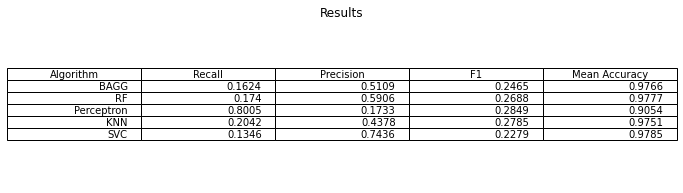

In [31]:
#Create a table with the results for each algorithm
fig, ax = plt.subplots()
ax.set_title("Results")
fig.set_size_inches(12, 3)
ax.axis('off')
ax.table(cellText=roundedResultsDF.values, colLabels=roundedResultsDF.columns, loc='center')
plt.show()